# temps de debut execution

In [72]:
import time
import datetime

# Marquer le début de l'exécution
start_time = time.time()
print(f"Exécution du notebook commencée à: {datetime.datetime.now()}")


Exécution du notebook commencée à: 2024-06-28 11:12:03.797993


# Préparation des données

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import joblib
import os

# Configurer MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Credit Risk Model")

# Charger le DataFrame
app_datas = pd.read_csv('../csv_files/app_datas_light.csv')

# Mode débogage
debug_mode = True

if debug_mode:
    # Utiliser un sous-ensemble du dataset pour le débogage
    app_datas = app_datas.sample(frac=0.15, random_state=42)

# Séparer les features et la cible
X = app_datas.drop(columns=['TARGET'])
y = app_datas['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Créer un pipeline avec imputation KNN, standardisation et SMOTE
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42))  # Équilibrage des classes avec SMOTE
])

# Appliquer le pipeline sur les données d'entraînement
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Transformer les données de test sans SMOTE
X_test_imputed = pipeline.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test_imputed)

print(f"Shape of X_train: {X_train_resampled.shape}")
print(f"Shape of X_test: {X_test_scaled.shape}")
print(f"Distribution in y_train: {pd.Series(y_train_resampled).value_counts(normalize=True)}")
print(f"Distribution in y_test: {pd.Series(y_test).value_counts(normalize=True)}")


Shape of X_train: (44084, 240)
Shape of X_test: (9226, 240)
Distribution in y_train: TARGET
0    0.769236
1    0.230764
Name: proportion, dtype: float64
Distribution in y_test: TARGET
0    0.918925
1    0.081075
Name: proportion, dtype: float64


In [74]:
app_datas['SK_ID_CURR']


245895    368274
98194     141653
36463     289560
249923    256074
158389    396861
           ...  
184534    331790
278880    296917
100888    150778
52983     449076
246391    159738
Name: SK_ID_CURR, Length: 46127, dtype: int64

# Modélisation

## fonction model

In [75]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def evaluate_and_log_model(model, model_name, model_type, params, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn

        # Logger les métriques et les hyperparamètres
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_params(params)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")


## Modèle Dummy

In [76]:
from sklearn.dummy import DummyClassifier

dummy_params = {"strategy": "most_frequent"}
dummy_clf = DummyClassifier(**dummy_params)
evaluate_and_log_model(dummy_clf, "dummy_classifier_model", "Dummy Classifier", dummy_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


dummy_classifier_model - AUC: 0.5
dummy_classifier_model - Accuracy: 0.9189247778018643
dummy_classifier_model - Cost: 7480


## Modèle Regression lineaire

In [77]:
from sklearn.linear_model import LogisticRegression

log_reg_params = {
    "penalty": 'l2',
    "C": 1.0,
    "class_weight": 'balanced',
    "random_state": 42,
    "max_iter": 1000
}
log_reg = LogisticRegression(**log_reg_params)
evaluate_and_log_model(log_reg, "logistic_regression_model", "Logistic Regression", log_reg_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


logistic_regression_model - AUC: 0.7287961732978593
logistic_regression_model - Accuracy: 0.6949924127465857
logistic_regression_model - Cost: 5334


## Modèle Random Forrest

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 100,
    "class_weight": 'balanced',
    "random_state": 42
}
rf_clf = RandomForestClassifier(**rf_params)
evaluate_and_log_model(rf_clf, "random_forest_model", "Random Forest", rf_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


random_forest_model - AUC: 0.6819351880236106
random_forest_model - Accuracy: 0.9191415564708433
random_forest_model - Cost: 7460


## Modèle XGBoost

In [79]:
from xgboost import XGBClassifier

xgb_params = {
    "objective": 'binary:logistic',
    "random_state": 42,
    "eval_metric": 'auc'
}
xgb_clf = XGBClassifier(**xgb_params)
evaluate_and_log_model(xgb_clf, "xgboost_model", "XGBoost", xgb_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


xgboost_model - AUC: 0.7044410635643308
xgboost_model - Accuracy: 0.9163234337741166
xgboost_model - Cost: 7333


## création du score personnalisé

In [80]:
from sklearn.metrics import make_scorer, confusion_matrix

# Définir une fonction pour calculer le coût
def custom_cost(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn
    return cost

# Créer un make_scorer à partir de la fonction custom_cost
cost_scorer = make_scorer(custom_cost, greater_is_better=False)


## Gridsearchcv sur XGBOost et log mlflow

In [81]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}

# Créer le modèle XGBoost
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Configurer GridSearchCV avec le score personnalisé
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=cost_scorer, cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "XGBoost with GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
       
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_xgboost_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_xgboost_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
Best model saved to ../models/best_xgboost_model.pkl
Best Model - AUC: 0.7048573659663956
Best Model - Accuracy: 0.9183828311294169
Best Model - Cost: 7404


## GridSearchCV avec Pipelines

L'intégration de pipelines dans le processus de GridSearch présente plusieurs avantages, notamment la simplification du flux de travail, l'élimination des fuites de données et l'automatisation des étapes de prétraitement. Voici comment et pourquoi vous pouvez intégrer des pipelines dans votre code de GridSearch.
Avantages de l'Intégration de Pipelines

    Simplification du Flux de Travail :
        En intégrant les étapes de prétraitement et de modélisation dans un pipeline, le code devient plus propre et plus facile à comprendre.

    Élimination des Fuites de Données :
        Lors de la validation croisée, il est crucial que les étapes de prétraitement soient ajustées uniquement sur les données d'entraînement et non sur les données de validation. Les pipelines assurent cette séparation.

    Automatisation et Reproductibilité :
        Les pipelines permettent d'automatiser l'ensemble du processus, garantissant que chaque étape est exécutée de manière cohérente. Cela rend également le processus reproductible.

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import joblib

# Définir les étapes du pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardiser les données
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Définir les hyperparamètres à tester
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 9],
    'xgb__n_estimators': [100, 200, 300]
}

# Configurer GridSearchCV avec le pipeline
grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "Pipeline with XGBoost and GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_pipeline_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_pipeline_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 200}
Best model saved to ../models/best_pipeline_model.pkl
Best Model - AUC: 0.7086916057035952
Best Model - Accuracy: 0.9188163884673748
Best Model - Cost: 7391


## Etude résultas model predict sur test

Ce code effectue une analyse des résultats de prédiction d'un modèle sur un jeu de données de test. Il calcule des statistiques sur les prédictions, crée une matrice de confusion, trace la courbe ROC, et calcule des métriques de performance comme la précision, le rappel, et le F1-score. Il affiche également une distribution des probabilités de prédiction et liste les identifiants de clients pour lesquels le modèle a prédit 0 ou 1.

Confusion Matrix:
[[8467   11]
 [ 738   10]]
AUC: 0.7086916057035952
Accuracy: 0.9188163884673748
Precision: 0.47619047619047616
Recall: 0.013368983957219251
F1 Score: 0.02600780234070221


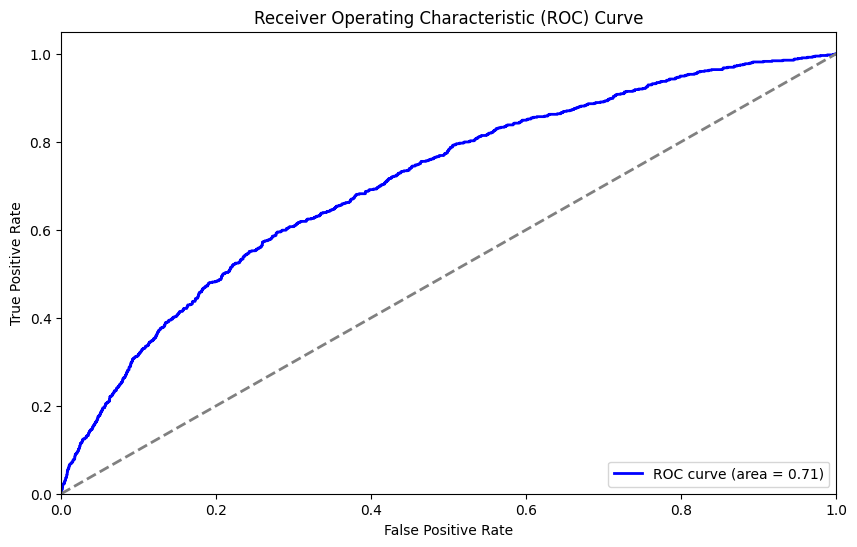

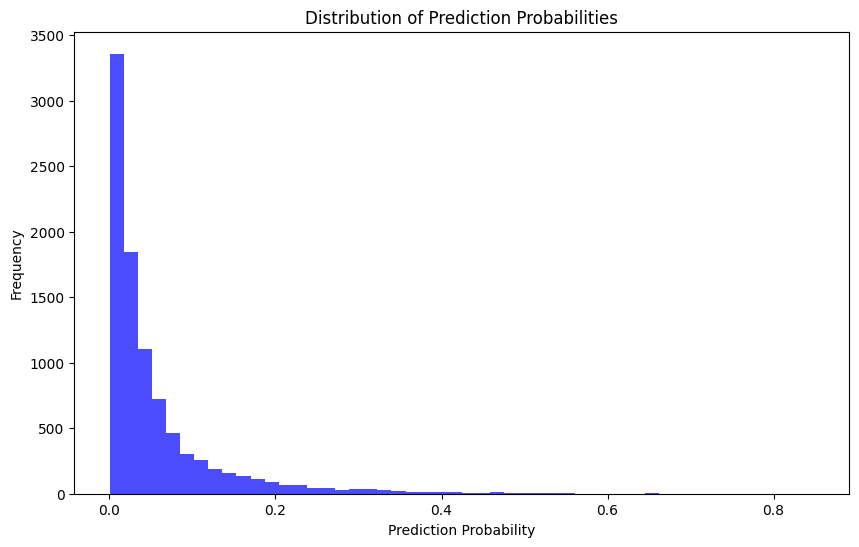

Threshold: 0.0
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.0810752221981357
Recall: 1.0
F1 Score: 0.14998997393222377

Threshold: 0.1
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.2004118050789293
Recall: 0.39037433155080214
F1 Score: 0.26485260770975055

Threshold: 0.2
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.24448897795591182
Recall: 0.16310160427807488
F1 Score: 0.19566960705693665

Threshold: 0.30000000000000004
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.2935323383084577
Recall: 0.07887700534759358
F1 Score: 0.12434141201264488

Threshold: 0.4
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.3484848484848485
Recall: 0.03074866310160428
F1 Score: 0.056511056511056514

Threshold: 0.5
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.47619047619047616
Recall: 0.013368983957219251
F1 Score: 0.02600780234070221

Threshold: 0.6000000000000001
Confusion Matrix:
[[8467   11]
 [ 738   10]]
Precision: 0.44444444444444

/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


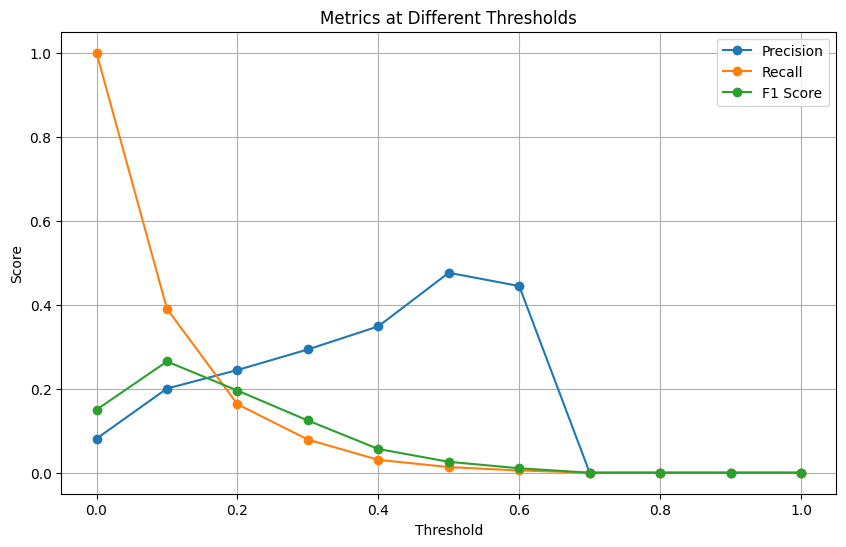

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Charger le modèle sauvegardé
model_path = '../models/best_pipeline_model.pkl'
best_model = joblib.load(model_path)

# Prédire les targets sur X_test_scaled
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculer les métriques de performance
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Afficher les métriques
print("Confusion Matrix:")
print(conf_matrix)
print(f"AUC: {auc_score}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Tracer la distribution des probabilités de prédiction
plt.figure(figsize=(10, 6))
plt.hist(y_proba, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.show()

# Analyser l'importance du seuil
thresholds = np.arange(0.0, 1.1, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_adjusted = (y_proba >= threshold).astype(int)
    precision_adjusted = precision_score(y_test, y_pred_adjusted)
    recall_adjusted = recall_score(y_test, y_pred_adjusted)
    f1_adjusted = f1_score(y_test, y_pred_adjusted)
    
    precisions.append(precision_adjusted)
    recalls.append(recall_adjusted)
    f1_scores.append(f1_adjusted)
    
    print(f"Threshold: {threshold}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision: {precision_adjusted}")
    print(f"Recall: {recall_adjusted}")
    print(f"F1 Score: {f1_adjusted}\n")

# Tracer les métriques en fonction du seuil
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## descriptions features

In [84]:
# Charger le fichier de description des colonnes avec l'encodage correct
try:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='utf-8')
except UnicodeDecodeError:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

# Filtrer pour obtenir uniquement les descriptions pertinentes pour les caractéristiques utilisées dans l'application {train|test}
feature_descriptions = columns_description[columns_description['Table'].str.contains('application_{train|test}.csv', na=False)]
feature_descriptions = feature_descriptions[['Row', 'Description']].set_index('Row')


# Feature importance

## globale

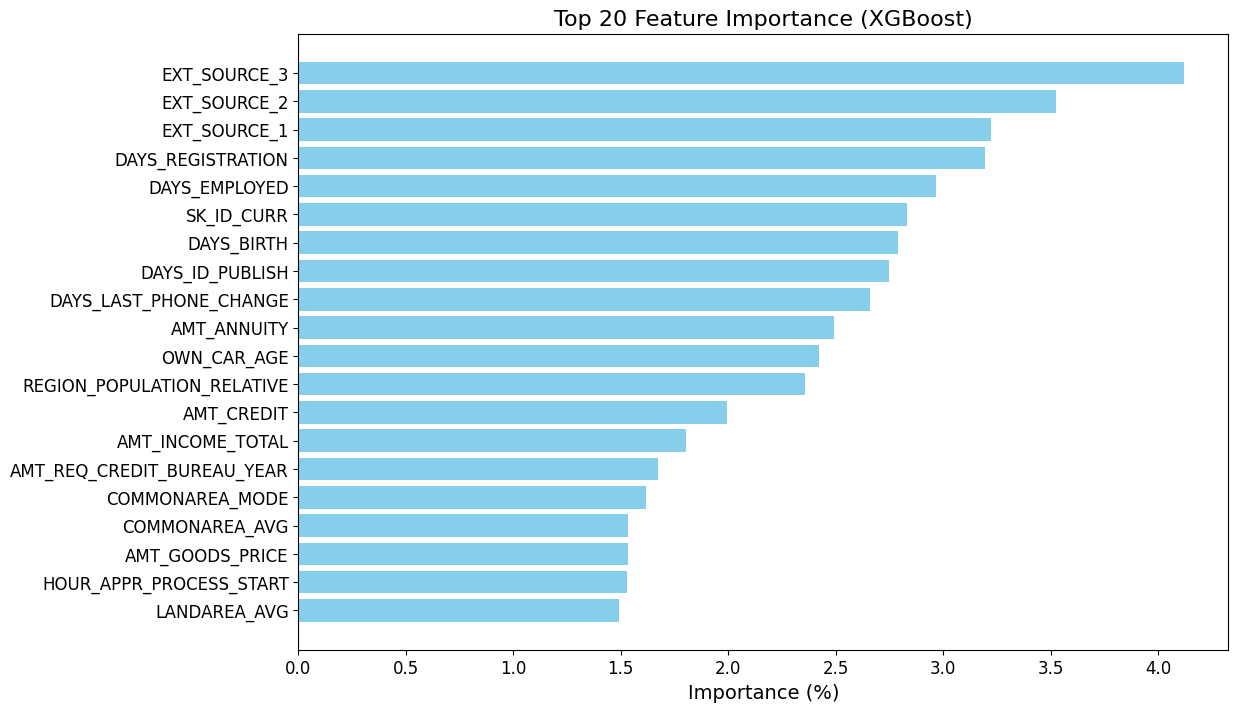

EXT_SOURCE_3: Normalized score from external data source
EXT_SOURCE_2: Normalized score from external data source
EXT_SOURCE_1: Normalized score from external data source
DAYS_REGISTRATION: How many days before the application did client change his registration
DAYS_EMPLOYED: How many days before the application the person started current employment
SK_ID_CURR: ID of loan in our sample
DAYS_BIRTH: Client's age in days at the time of application
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone
AMT_ANNUITY: Loan annuity
OWN_CAR_AGE: Age of client's car
REGION_POPULATION_RELATIVE: Normalized population of region where client lives (higher number means the client lives in more populated region)
AMT_CREDIT: Credit amount of the loan
AMT_INCOME_TOTAL: Income of the client
AMT_REQ_CREDIT_BUREAU_YEAR: Number of enquiries to Credit Bure

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier, plot_importance

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
# best_model = grid_search.best_estimator_

#ajustement necessaire depuis qu'on utilise pipeline

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Extraire l'importance des caractéristiques
importance = best_model.get_booster().get_score(importance_type='weight')

# Convertir en DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Assigner des noms significatifs aux features basées sur leur ordre dans les données d'origine
feature_names = X_train.columns
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])

# Ajouter les descriptions des caractéristiques
importance_df['Description'] = importance_df['Feature'].map(feature_descriptions['Description'])

# Remplacer les valeurs NaN dans les descriptions par une chaîne vide pour éviter les erreurs
importance_df['Description'] = importance_df['Description'].fillna('')

# Trier les caractéristiques par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Calculer le pourcentage d'importance
importance_df['Importance'] = 100 * (importance_df['Importance'] / importance_df['Importance'].sum())

# Afficher les 20 premières caractéristiques
top_20_features = importance_df.head(20)

plt.figure(figsize=(12, 8))  # Ajustez la taille de la figure pour plus de lisibilité
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance (%)', fontsize=14)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Afficher le graphique
plt.show()

# Afficher les descriptions des 20 premières caractéristiques
descriptions = [f"{feature}: {desc}" for feature, desc in zip(top_20_features['Feature'], top_20_features['Description'])]

# Utiliser print pour afficher les descriptions
for description in descriptions:
    print(description)


## locale

Crédit accepté


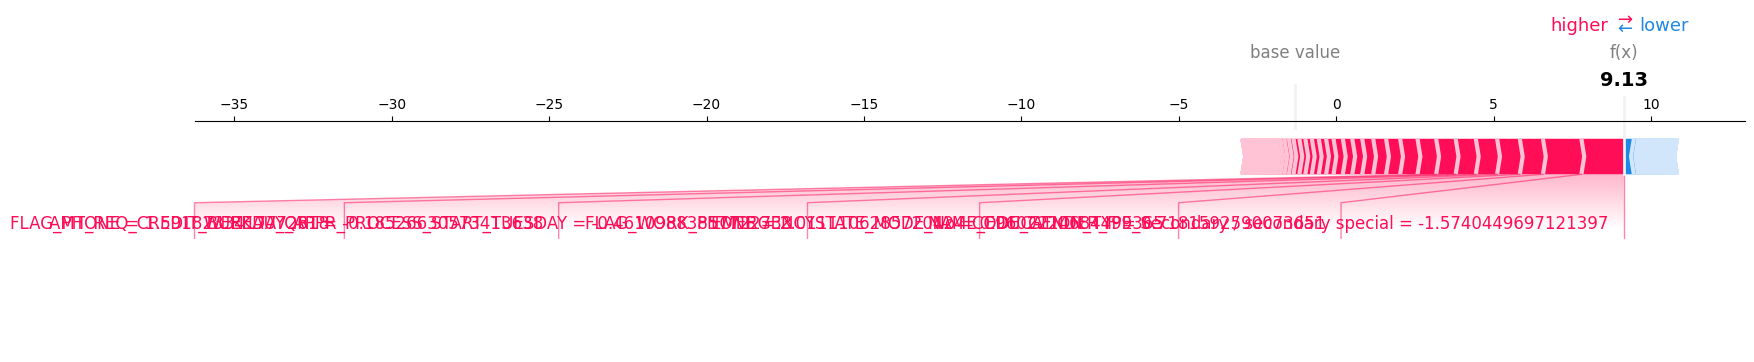

Crédit refusé


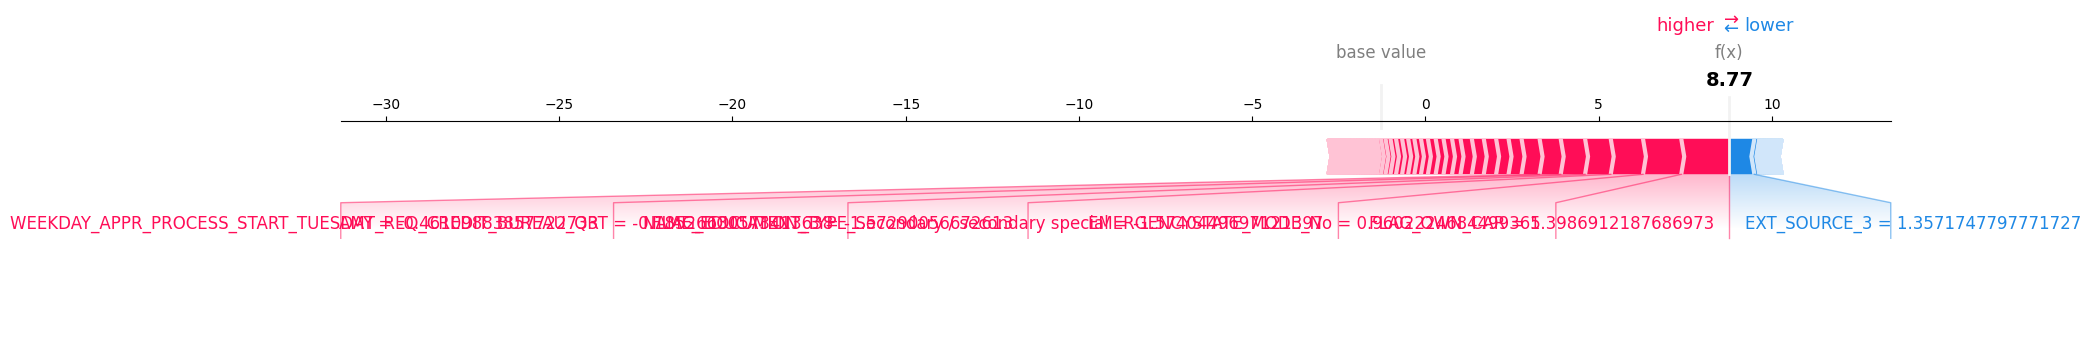

In [89]:
import shap

# Extraire le modèle XGBoost du pipeline
best_model = best_pipeline.named_steps['xgb']  # Extraire le modèle XGBoost du pipeline


# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(best_model)

# Sélectionner un client avec une cible de 0 et un client avec une cible de 1
indices_target_0 = y_test[y_test == 0].index
indices_target_1 = y_test[y_test == 1].index

# Vérifier que les indices existent
if len(indices_target_0) > 0:
    index_target_0 = indices_target_0[0]
    # Convertir l'index global en index relatif
    relative_index_target_0 = y_test.index.get_loc(index_target_0)
    X_target_0 = X_test_scaled[relative_index_target_0].reshape(1, -1)
    shap_values_target_0 = explainer.shap_values(X_target_0)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 0
    print("Crédit accepté")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_0, X_target_0, feature_names=feature_names, matplotlib=True)

if len(indices_target_1) > 0:
    index_target_1 = indices_target_1[0]
    # Convertir l'index global en index relatif
    relative_index_target_1 = y_test.index.get_loc(index_target_1)
    X_target_1 = X_test_scaled[relative_index_target_1].reshape(1, -1)
    shap_values_target_1 = explainer.shap_values(X_target_1)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 1
    print("Crédit refusé")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_1, X_target_1, feature_names=feature_names, matplotlib=True)


# temps de fin d'execution

In [ ]:
# Marquer la fin de l'exécution
end_time = time.time()

# Calculer le temps d'exécution total
execution_time = end_time - start_time
execution_time_str = str(datetime.timedelta(seconds=execution_time))

print(f"Exécution du notebook terminée à: {datetime.datetime.now()}")
print(f"Temps d'exécution total: {execution_time_str}")


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   4.0s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=  23.5s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=300; total time= 2.0min
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=100; total time=  19.5s
[CV] END ...learning_rate=0.2, max_depth=9, n_estimators=300; total time=  34.2s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  12.4s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=200; total time= 1.4min
[CV] END xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=200; total time=  55.1s
[CV] END xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=  28.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  10.8s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=10